covid detection by mobilenets and accuracy 99%

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.models import Model,load_model
from keras.layers import Flatten
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix
import random
import matplotlib.pyplot as plt
import shutil
import os
import cv2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#We copied the data so that we can modify it
import os
os.makedirs('/kaggle/working/train')
from distutils.dir_util import copy_tree
fromd=r'/kaggle/input/covid-cxr-image-dataset-research/COVID_IEEE'
to=r'/kaggle/working/train'
copy_tree(fromd,to)

['/kaggle/working/train/normal/NORMAL2-IM-0771-0001.jpeg',
 '/kaggle/working/train/normal/IM-0421-0001.jpeg',
 '/kaggle/working/train/normal/NORMAL2-IM-0531-0001.jpeg',
 '/kaggle/working/train/normal/NORMAL2-IM-0416-0001-0002.jpeg',
 '/kaggle/working/train/normal/NORMAL2-IM-0627-0001.jpeg',
 '/kaggle/working/train/normal/NORMAL2-IM-0757-0001.jpeg',
 '/kaggle/working/train/normal/NORMAL2-IM-0696-0001.jpeg',
 '/kaggle/working/train/normal/NORMAL2-IM-0808-0001.jpeg',
 '/kaggle/working/train/normal/IM-0101-0001.jpeg',
 '/kaggle/working/train/normal/IM-0304-0001.jpeg',
 '/kaggle/working/train/normal/NORMAL2-IM-0385-0001.jpeg',
 '/kaggle/working/train/normal/NORMAL2-IM-0908-0001.jpeg',
 '/kaggle/working/train/normal/NORMAL2-IM-0428-0001.jpeg',
 '/kaggle/working/train/normal/NORMAL2-IM-0399-0001.jpeg',
 '/kaggle/working/train/normal/IM-0461-0001.jpeg',
 '/kaggle/working/train/normal/IM-0013-0001.jpeg',
 '/kaggle/working/train/normal/IM-0103-0001.jpeg',
 '/kaggle/working/train/normal/NORMAL2-I

In [3]:
# we splite data to train ,test. validation
if not os.path.isdir(r'/kaggle/working/valid'):
    os.makedirs(r'/kaggle/working/valid')
    os.makedirs(r'/kaggle/working/test')
    for label in os.listdir(r'/kaggle/working/train'):
        valid_images=random.sample(os.listdir(r'/kaggle/working/train/'+label),int(len(os.listdir('/kaggle/working/train/'+label))*.20))
        for image in valid_images:
            if not os.path.isdir(f'/kaggle/working/valid/{label}'):
                os.makedirs(f'/kaggle/working/valid/{label}')
            shutil.move(f'/kaggle/working/train/{label}/{image}',f'/kaggle/working/valid/{label}')
        test_images=random.sample(os.listdir(r'/kaggle/working/valid/'+label),int(len(os.listdir('/kaggle/working/valid/'+label))*.50))

        for image in test_images:
            if not os.path.isdir(f'/kaggle/working/test/{label}'):
                os.makedirs(f'/kaggle/working/test/{label}')
            shutil.move(f'/kaggle/working/valid/{label}/{image}',f'/kaggle/working/test/{label}')

In [4]:
train_path = r'/kaggle/working/train'
valid_path = r'/kaggle/working/valid'
test_path = r'/kaggle/working/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=124)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=124)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=124, shuffle=False)

Found 1372 images belonging to 3 classes.
Found 169 images belonging to 3 classes.
Found 167 images belonging to 3 classes.


0.0
0.0
0.0
1.0
0.0
1.0


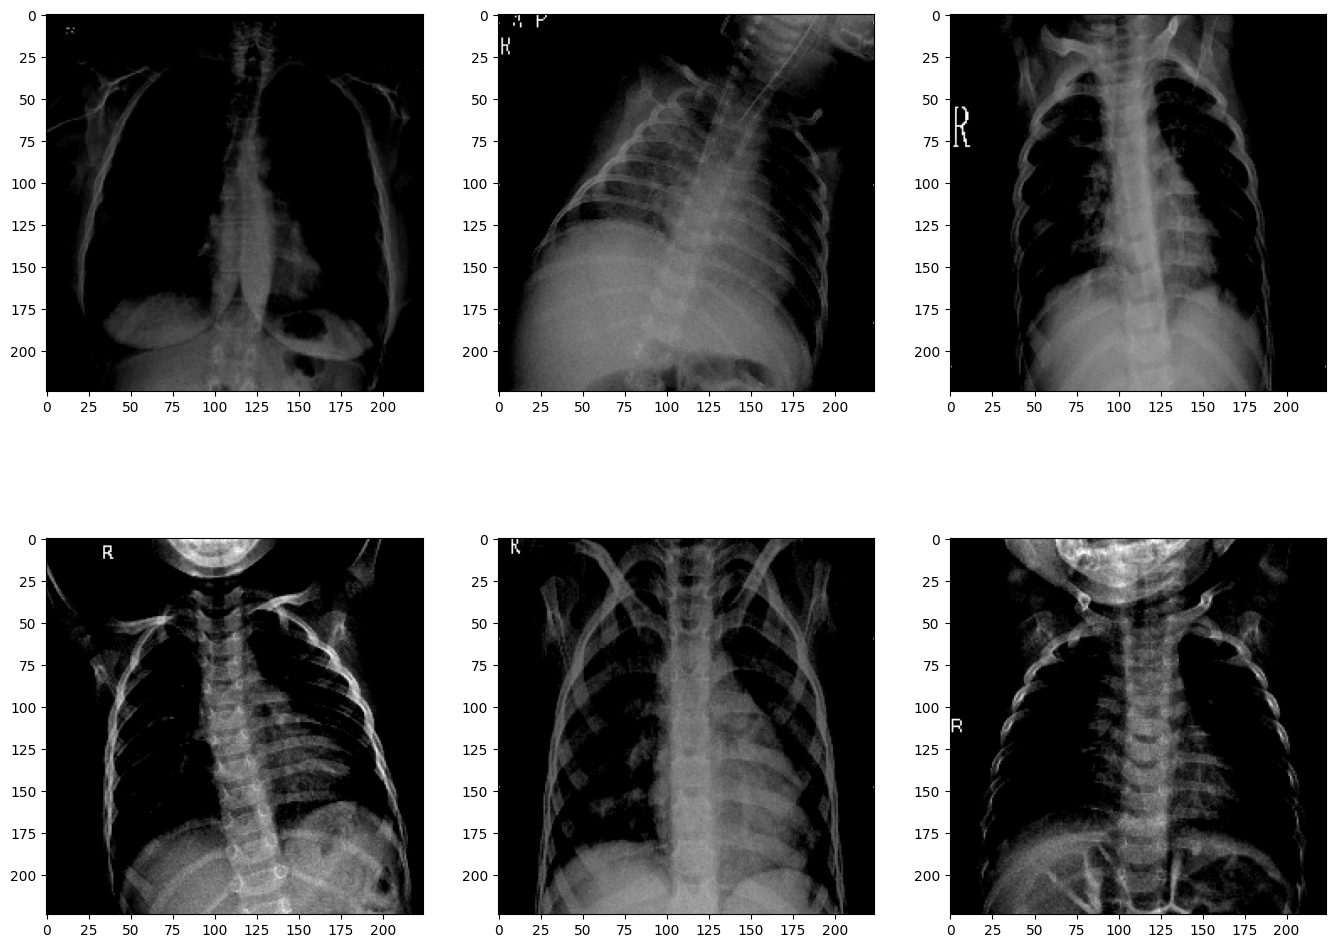

In [5]:
#imshow some data and labels
fig,axs=plt.subplots(2,3)
for row in range(2):
    for columns in range(3):
        img, label = train_batches.next()
        axs[row,columns].imshow(img[0])
        print(label[0][1])


plt.subplots_adjust(left=0,right=2,bottom=0,top=2)
   


In [6]:
#we load data , process image to input it to model and resize image to (224,224)
# you can download data from https://www.kaggle.com/pranavraikokte/covid19-image-dataset
#you use covid and normar image only , you split it to train , test and valid

In [7]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [8]:
#we load model and show model layers

In [9]:
x = mobile.layers[-6].output
x

<KerasTensor: shape=(None, 7, 7, 1024) dtype=float32 (created by layer 'conv_pw_13_relu')>

In [10]:
#we delete last 6 layer

In [11]:
output=Flatten(name='flatten')(x)
output=Dense(128,activation='relu')(output)
output = Dense(units=3, activation='softmax')(output)


In [12]:
# tune model for covid data

In [13]:
model = Model(inputs=mobile.input, outputs=output)


In [14]:
#we concatenate model

In [15]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [16]:
#freez first 23 layer

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [18]:

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [19]:
#we compile model 

In [20]:
#train model 
tf.random.set_seed(42)
ebochs=30
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='min')
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=2, mode='min')

history=model.fit(train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=ebochs,callbacks=[early_stop,checkpoint],
    verbose=2
)

Epoch 1/30

Epoch 1: val_loss improved from inf to 60.38520, saving model to best_model.h5
12/12 - 33s - loss: 5.4242 - accuracy: 0.7544 - val_loss: 60.3852 - val_accuracy: 0.3669 - 33s/epoch - 3s/step
Epoch 2/30

Epoch 2: val_loss improved from 60.38520 to 52.96467, saving model to best_model.h5
12/12 - 19s - loss: 1.0104 - accuracy: 0.9570 - val_loss: 52.9647 - val_accuracy: 0.3669 - 19s/epoch - 2s/step
Epoch 3/30

Epoch 3: val_loss improved from 52.96467 to 19.38505, saving model to best_model.h5
12/12 - 19s - loss: 0.1144 - accuracy: 0.9869 - val_loss: 19.3850 - val_accuracy: 0.4083 - 19s/epoch - 2s/step
Epoch 4/30

Epoch 4: val_loss did not improve from 19.38505
12/12 - 19s - loss: 0.0641 - accuracy: 0.9942 - val_loss: 25.6525 - val_accuracy: 0.3728 - 19s/epoch - 2s/step
Epoch 5/30

Epoch 5: val_loss did not improve from 19.38505
12/12 - 19s - loss: 0.0158 - accuracy: 0.9971 - val_loss: 29.2872 - val_accuracy: 0.3728 - 19s/epoch - 2s/step
Epoch 6/30

Epoch 6: val_loss improved fro

In [21]:
# Define the path to the model weights file
weights_path = '/kaggle/working/best_model.h5'



# Load the weights into the model
model.load_weights(weights_path)

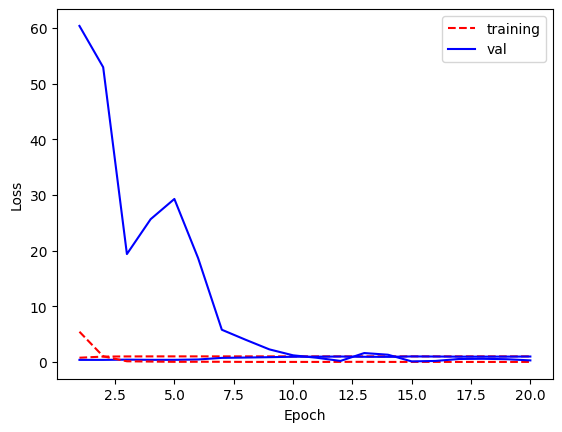

In [22]:
# we plot accuraccy and loss
training_acc = history.history['accuracy']

training_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, val_acc, 'b-')
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['training', 'val'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [23]:
#we train model and use specific randome seed to have specific accuracy dont change every train my model

In [24]:
test_labels = test_batches.classes
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [25]:
#we show actual classes of test data

In [26]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [27]:
prediction=np.argmax(predictions,axis=-1)

In [28]:
accuracy=sum(prediction==test_labels)/len(prediction)
accuracy

0.9401197604790419

In [29]:
#we pridect test data

In [30]:
confusion_matrix = confusion_matrix(test_labels,predictions.argmax(axis=1))
confusion_matrix
print(classification_report(test_labels, predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        40
           1       0.93      0.95      0.94        66
           2       0.95      0.92      0.93        61

    accuracy                           0.94       167
   macro avg       0.94      0.94      0.94       167
weighted avg       0.94      0.94      0.94       167



In [31]:
#we compare pridected data with actual data and make confusion matrix

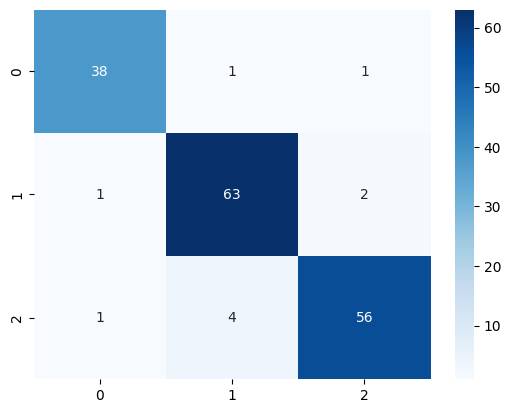

In [32]:
sn.heatmap(confusion_matrix, annot=True, cmap=plt.cm.Blues)
plt.show()

In [33]:
#we show confusion matrix by matplotlib 


In [34]:
#predict custom image
label={}
for i in train_batches.class_indices.keys():
    label[train_batches.class_indices[i]]=i
def prdict_custom_image(path):
    image=cv2.imread(path)
    image=cv2.resize(image,(224,224))

    image=np.expand_dims(image,axis=0)
    image=tf.keras.applications.mobilenet.preprocess_input(image)
    prediction_image=np.argmax(model.predict(image,verbose=0),axis=-1)
    return label[prediction_image[0]]


In [35]:
prdict_custom_image('/kaggle/input/covid-cxr-image-dataset-research/COVID_IEEE/normal/IM-0006-0001.jpeg')

'normal'